# Session 9: Cointegration and Vector Error Correction Models (VECM)

## Summer School: Time Series Methods for Finance and Economics

### Learning Objectives

By the end of this session, you will be able to:
1. Understand the concept of cointegration and spurious regression
2. Test for cointegration using Engle-Granger and Johansen procedures
3. Specify and estimate Vector Error Correction Models (VECM)
4. Interpret long-run equilibrium relationships
5. Distinguish between short-run and long-run dynamics
6. Apply cointegration to pairs trading strategies
7. Test restrictions on cointegrating vectors
8. Generate forecasts from VECM models

### Prerequisites
- Session 8: Vector Autoregression (VAR)
- Understanding of integration and unit roots
- Knowledge of error correction mechanisms

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.api import VAR, VECM
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen, select_order, select_coint_rank
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.filters.hp_filter import hpfilter
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.precision', 4)

## 1. Cointegration: Concept and Motivation

### 1.1 The Problem of Spurious Regression

**Classic problem**: Regressing one I(1) series on another I(1) series can give spurious results.

**Spurious regression** (Granger & Newbold, 1974):
- High $R^2$ even when no relationship exists
- Significant t-statistics
- Low Durbin-Watson statistic
- Results driven by common trends, not true relationship

**Example**: Ice cream sales and drownings both trend up in summer.

### 1.2 Definition of Cointegration

**Cointegration** (Engle & Granger, 1987):

Variables $y_t$ and $x_t$ are **cointegrated** if:
1. Both are I(1) (non-stationary)
2. A linear combination is I(0) (stationary)

$$z_t = y_t - \beta x_t \sim I(0)$$

where $\beta$ is the **cointegrating parameter**.

### 1.3 Economic Interpretation

**Long-run equilibrium relationship**:
- Variables cannot drift apart indefinitely
- Deviations from equilibrium are temporary
- Economic forces pull them back together

**Examples**:
1. **Spot and futures prices**: Arbitrage ensures they move together
2. **Exchange rates and purchasing power**: PPP theory
3. **Money supply and prices**: Quantity theory
4. **Wages and prices**: Labor market equilibrium
5. **Related stock prices**: Similar companies, ETF and components

### 1.4 Multivariate Extension

For N variables in $\mathbf{y}_t$, all I(1):

**Cointegration**: There exist vectors $\boldsymbol{\beta}$ such that:
$$\boldsymbol{\beta}^\top \mathbf{y}_t \sim I(0)$$

**Cointegration rank** $r$: Number of linearly independent cointegrating vectors.
- $0 \leq r \leq N-1$
- $r = 0$: No cointegration
- $r = N$: All variables stationary


Spurious Regression Example

Two independent random walks:
  Slope (β): 0.4198
  P-value: 0.0000
  R²: 0.4708

  ✗ SPURIOUS: Appears significant but variables are independent!


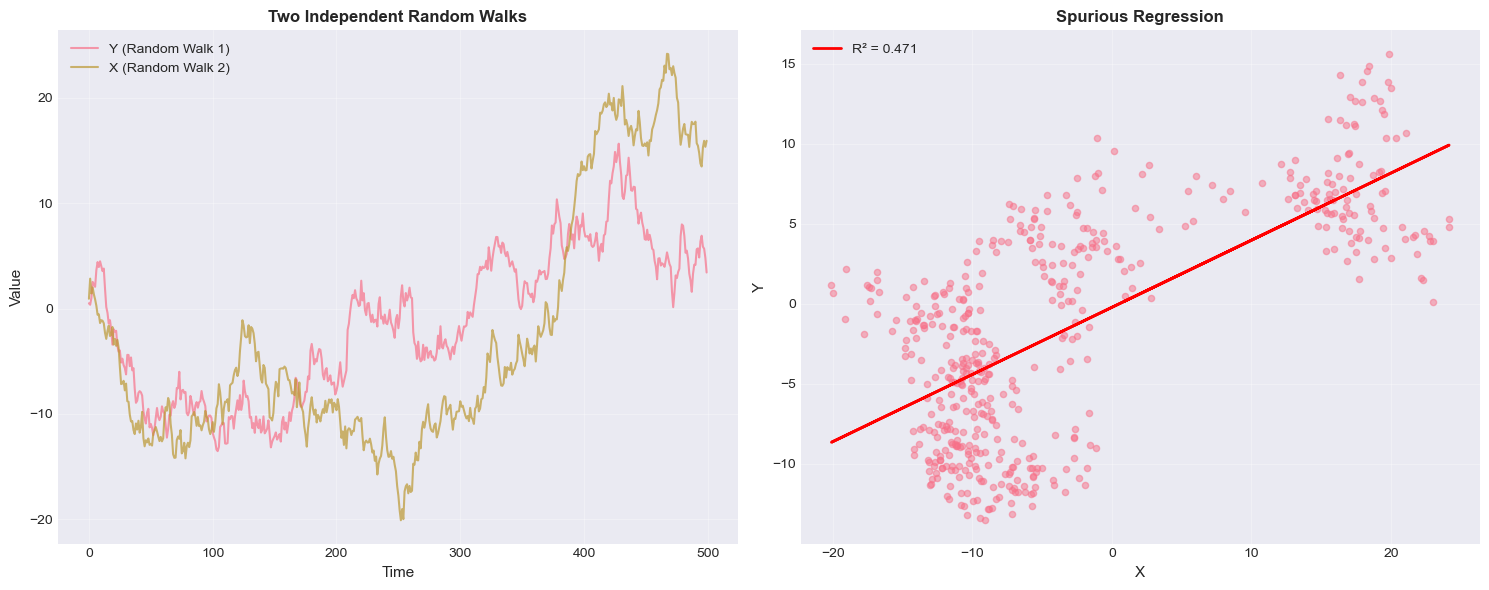


Lesson: Standard regression with I(1) variables is problematic!


In [3]:
# Demonstrate spurious regression
print("\n" + "="*60)
print("Spurious Regression Example")
print("="*60)

# Generate two independent random walks
np.random.seed(42)
T = 500
e1 = np.random.normal(0, 1, T)
e2 = np.random.normal(0, 1, T)

# Create random walks (I(1) processes)
y = np.cumsum(e1)
x = np.cumsum(e2)

# Spurious regression
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(x, y)

print("\nTwo independent random walks:")
print(f"  Slope (β): {slope:.4f}")
print(f"  P-value: {p_value:.4f}")
print(f"  R²: {r_value**2:.4f}")

if p_value < 0.05:
    print(f"\n  ✗ SPURIOUS: Appears significant but variables are independent!")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Time series
axes[0].plot(y, linewidth=1.5, label='Y (Random Walk 1)', alpha=0.7)
axes[0].plot(x, linewidth=1.5, label='X (Random Walk 2)', alpha=0.7)
axes[0].set_title('Two Independent Random Walks', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Time', fontsize=11)
axes[0].set_ylabel('Value', fontsize=11)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Scatter plot
axes[1].scatter(x, y, alpha=0.5, s=20)
axes[1].plot(x, intercept + slope * x, 'r-', linewidth=2,
            label=f'R² = {r_value**2:.3f}')
axes[1].set_xlabel('X', fontsize=11)
axes[1].set_ylabel('Y', fontsize=11)
axes[1].set_title('Spurious Regression', fontsize=12, fontweight='bold')
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nLesson: Standard regression with I(1) variables is problematic!")

In [7]:
# Download financial data that might be cointegrated
print("\n" + "="*60)
print("Downloading Financial Data")
print("="*60)

# Example 1: Related stocks (e.g., KO and PEP - Coca-Cola and Pepsi)
# Example 2: ETF and its major component
tickers = ['KO', 'PEP']  # Related companies in same industry

data = yf.download(tickers, start='2010-01-01', end='2024-01-01', progress=False)['Close']
data = data.dropna()

print(f"\nData: Coca-Cola (KO) and PepsiCo (PEP)")
print(f"Period: {data.index[0].date()} to {data.index[-1].date()}")
print(f"Observations: {len(data)}")
print(f"\nRationale: Similar companies in beverage industry")
print("Expected: Prices should move together (arbitrage)")

# Use log prices
log_prices = np.log(data)
log_prices.columns = ['KO', 'PEP']

print("\nDescriptive Statistics (Log Prices):")
print(log_prices.describe().round(4))



Data: Coca-Cola (KO) and PepsiCo (PEP)
Period: 2010-01-04 to 2023-12-29
Observations: 3522

Rationale: Similar companies in beverage industry
Expected: Prices should move together (arbitrage)

Descriptive Statistics (Log Prices):
              KO        PEP
count  3522.0000  3522.0000
mean      3.5035     4.3819
std       0.3372     0.4490
min       2.7365     3.5987
25%       3.2780     4.0203
50%       3.4915     4.3918
75%       3.7811     4.7412
max       4.0811     5.1865


In [9]:
# Test for unit roots
def test_unit_root(series, name):
    """
    Test for unit root using ADF test.
    """
    adf_result = adfuller(series, autolag='AIC')
    
    print(f"\n{name}:")
    print(f"  ADF Statistic: {adf_result[0]:.4f}")
    print(f"  P-value: {adf_result[1]:.4f}")
    print(f"  Critical Values:")
    for key, value in adf_result[4].items():
        print(f"    {key}: {value:.4f}")
    
    if adf_result[1] > 0.05:
        print(f"  → I(1): Cannot reject unit root")
        return True  # Has unit root
    else:
        print(f"  → I(0): Stationary")
        return False

print("\n" + "="*60)
print("Unit Root Tests (Levels)")
print("="*60)

unit_roots = {}
for col in log_prices.columns:
    unit_roots[col] = test_unit_root(log_prices[col], col)

if all(unit_roots.values()):
    print("\n✓ Both series are I(1) → Cointegration is possible")
else:
    print("\n✗ Not all series are I(1) → Cointegration not applicable")


Unit Root Tests (Levels)

KO:
  ADF Statistic: -1.4022
  P-value: 0.5812
  Critical Values:
    1%: -3.4322
    5%: -2.8624
    10%: -2.5672
  → I(1): Cannot reject unit root

PEP:
  ADF Statistic: -0.7813
  P-value: 0.8246
  Critical Values:
    1%: -3.4322
    5%: -2.8624
    10%: -2.5672
  → I(1): Cannot reject unit root

✓ Both series are I(1) → Cointegration is possible


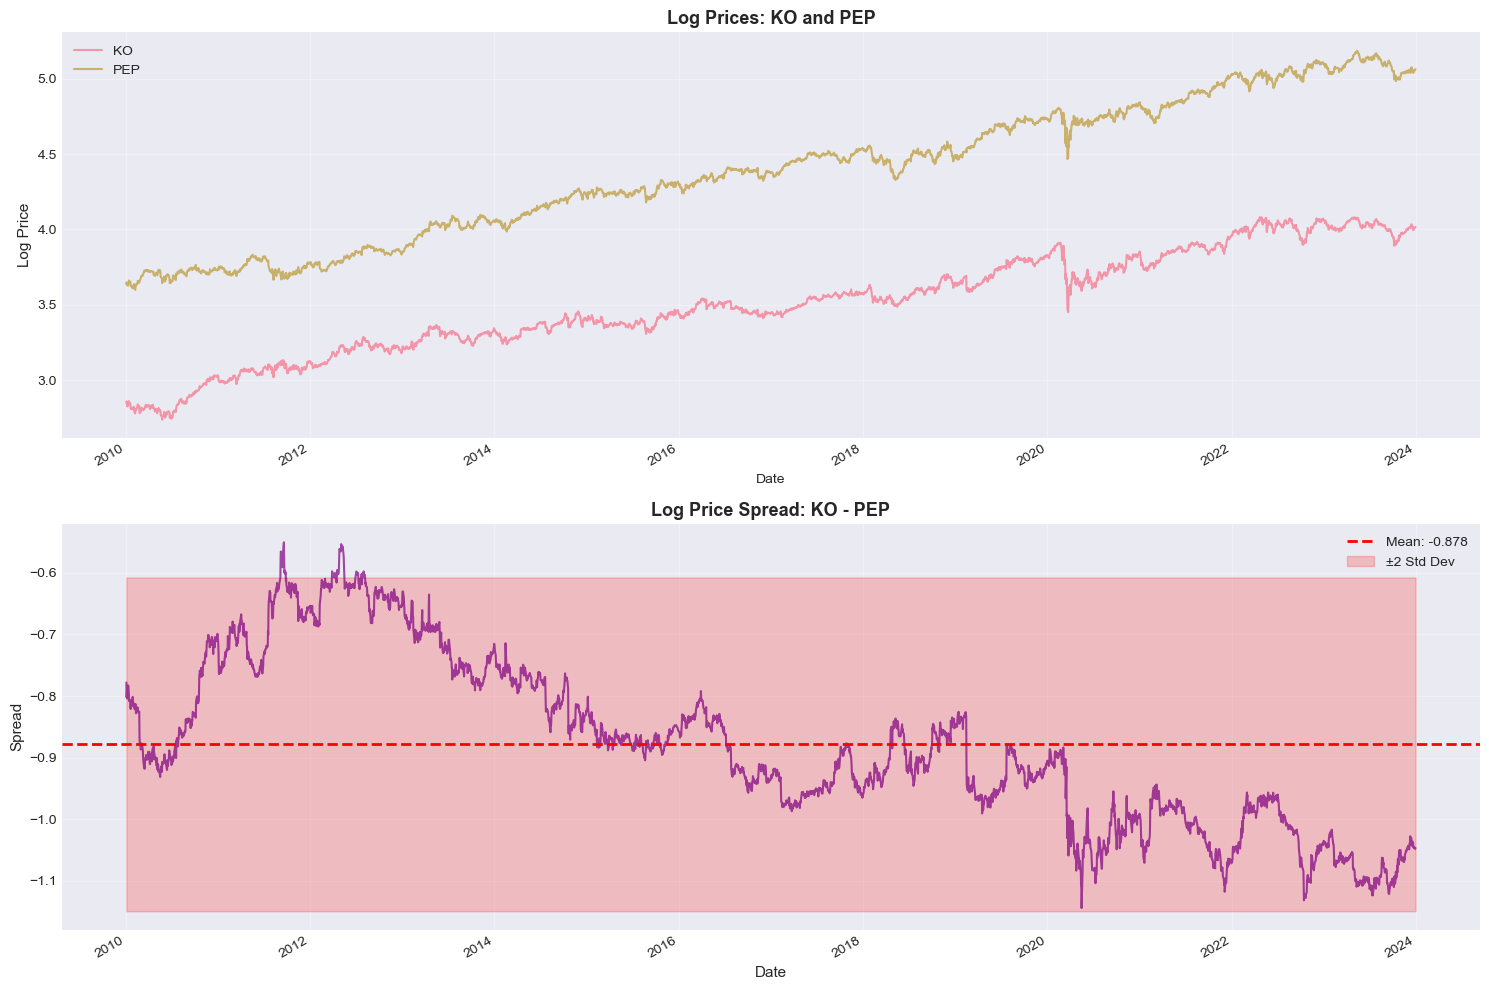


Observations:
• Both series trend (non-stationary)
• Spread appears mean-reverting (stationary)
• Suggests cointegration relationship


In [11]:
# Visualize the series
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Log prices
log_prices.plot(ax=axes[0], linewidth=1.5, alpha=0.7)
axes[0].set_title('Log Prices: KO and PEP', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Log Price', fontsize=11)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Price ratio (potential cointegrating relationship)
ratio = log_prices['KO'] - log_prices['PEP']
ratio.plot(ax=axes[1], linewidth=1.5, color='purple', alpha=0.7)
axes[1].axhline(y=ratio.mean(), color='red', linestyle='--', 
               label=f'Mean: {ratio.mean():.3f}', linewidth=2)
axes[1].fill_between(ratio.index, 
                     ratio.mean() - 2*ratio.std(), 
                     ratio.mean() + 2*ratio.std(),
                     alpha=0.2, color='red', label='±2 Std Dev')
axes[1].set_title('Log Price Spread: KO - PEP', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Spread', fontsize=11)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservations:")
print("• Both series trend (non-stationary)")
print("• Spread appears mean-reverting (stationary)")
print("• Suggests cointegration relationship")

## 2. Testing for Cointegration

### 2.1 Engle-Granger Two-Step Method

**Step 1**: Estimate cointegrating regression by OLS:
$$y_t = \alpha + \beta x_t + u_t$$

**Step 2**: Test if residuals $\hat{u}_t$ are stationary using ADF test.

**Null hypothesis**: No cointegration ($\hat{u}_t$ has unit root)

**Critical values**: Different from standard ADF (MacKinnon, 1991)

**Advantages**:
- Simple and intuitive
- Works for bivariate case

**Disadvantages**:
- Assumes single cointegrating vector
- Asymmetric treatment of variables
- Less powerful for multiple variables

### 2.2 Johansen Procedure

**Maximum likelihood approach** for multivariate cointegration.

**Tests**:
1. **Trace test**: $H_0: r \leq r_0$ vs $H_1: r > r_0$
   $$\lambda_{\text{trace}}(r) = -T \sum_{i=r+1}^N \ln(1-\hat{\lambda}_i)$$

2. **Maximum eigenvalue test**: $H_0: r = r_0$ vs $H_1: r = r_0 + 1$
   $$\lambda_{\max}(r) = -T \ln(1-\hat{\lambda}_{r+1})$$

where $\hat{\lambda}_i$ are ordered eigenvalues.

**Advantages**:
- Handles multiple cointegrating vectors
- Tests for rank
- Symmetric treatment
- Allows restrictions

### 2.3 Interpretation

**If cointegrated**:
- Use VECM (not VAR in differences)
- Model long-run relationship
- Short-run dynamics around equilibrium

**If not cointegrated**:
- Use VAR in differences
- No long-run relationship

In [13]:
# Engle-Granger two-step test
print("\n" + "="*60)
print("Engle-Granger Cointegration Test")
print("="*60)

# Step 1: Cointegrating regression
from sklearn.linear_model import LinearRegression

X = log_prices['PEP'].values.reshape(-1, 1)
y = log_prices['KO'].values

reg = LinearRegression()
reg.fit(X, y)

beta = reg.coef_[0]
alpha = reg.intercept_
residuals = y - (alpha + beta * X.flatten())

print("\nStep 1: Cointegrating Regression")
print(f"  KO = {alpha:.4f} + {beta:.4f} * PEP + u")
print(f"  β (cointegrating parameter): {beta:.4f}")

# Step 2: Test residuals for stationarity
print("\nStep 2: Test Residuals for Unit Root")
adf_resid = adfuller(residuals, maxlag=1, autolag=None)

print(f"  ADF Statistic: {adf_resid[0]:.4f}")
print(f"  P-value: {adf_resid[1]:.4f}")

# Use statsmodels coint function for proper critical values
eg_test = coint(log_prices['KO'], log_prices['PEP'])
print(f"\nEngle-Granger Test (statsmodels):")
print(f"  Test Statistic: {eg_test[0]:.4f}")
print(f"  P-value: {eg_test[1]:.4f}")
print(f"  Critical Values (10%, 5%, 1%): {eg_test[2]}")

if eg_test[1] < 0.05:
    print(f"\n  ✓ Reject null → Series are COINTEGRATED")
else:
    print(f"\n  ✗ Cannot reject null → No cointegration")


Engle-Granger Cointegration Test

Step 1: Cointegrating Regression
  KO = 0.2764 + 0.7365 * PEP + u
  β (cointegrating parameter): 0.7365

Step 2: Test Residuals for Unit Root
  ADF Statistic: -3.6349
  P-value: 0.0051

Engle-Granger Test (statsmodels):
  Test Statistic: -3.4855
  P-value: 0.0337
  Critical Values (10%, 5%, 1%): [-3.89955316 -3.33786588 -3.04565476]

  ✓ Reject null → Series are COINTEGRATED


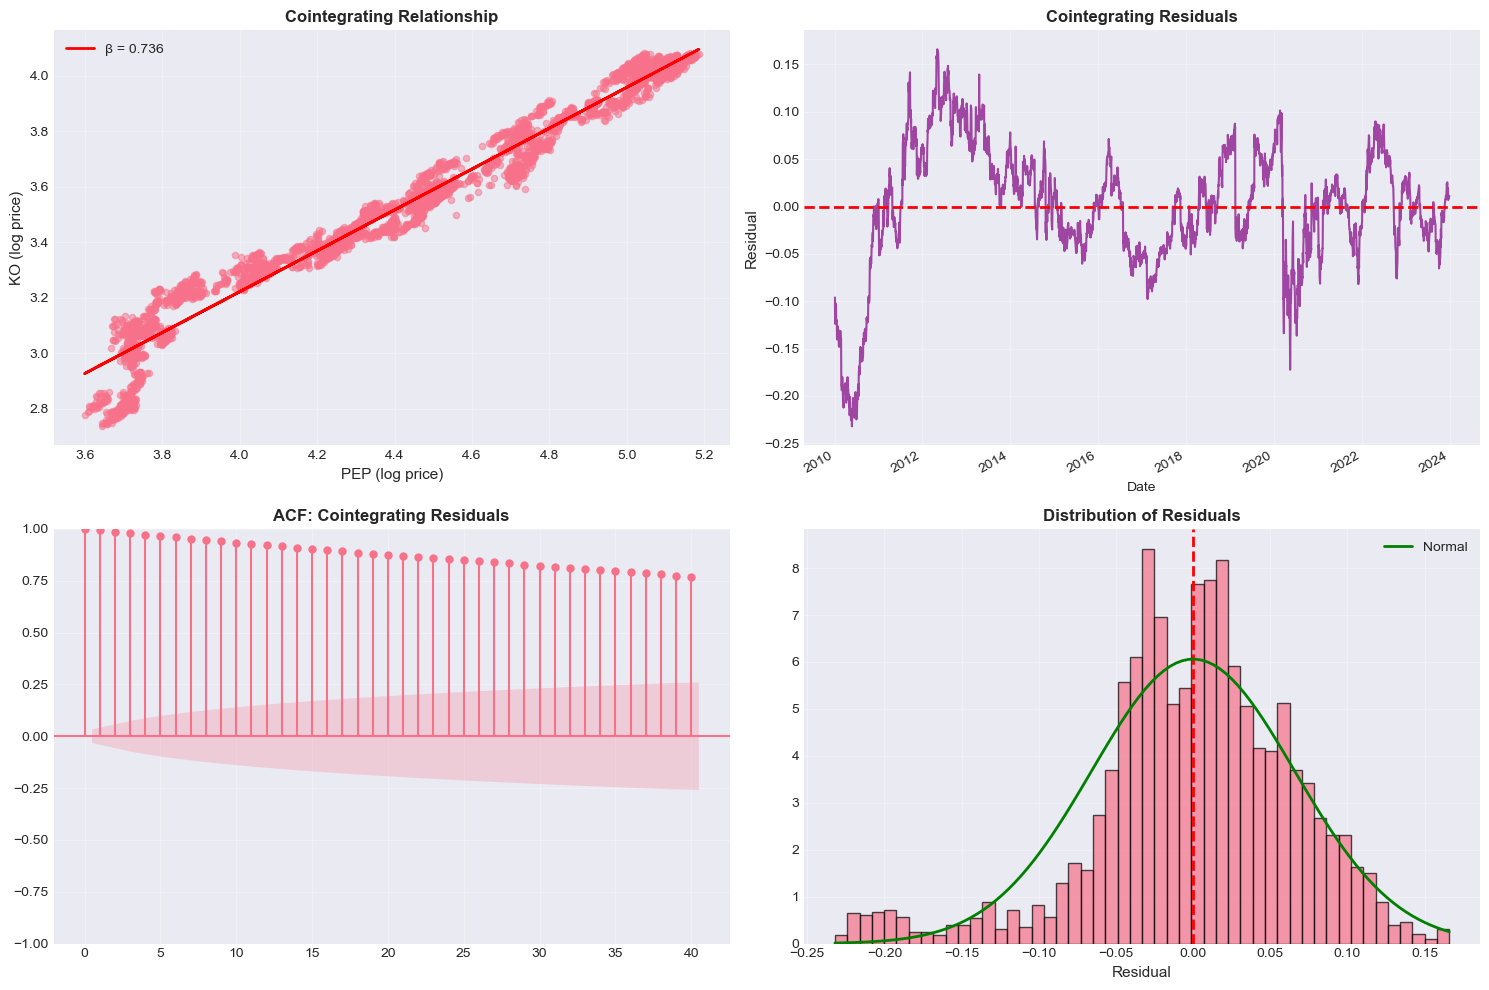


Key Observations:
• Strong linear relationship between prices
• Residuals are stationary (mean-reverting)
• ACF decays quickly → no unit root


In [14]:
# Visualize cointegrating relationship
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Scatter plot with regression line
axes[0, 0].scatter(log_prices['PEP'], log_prices['KO'], alpha=0.5, s=20)
axes[0, 0].plot(log_prices['PEP'], alpha + beta * log_prices['PEP'], 
               'r-', linewidth=2, label=f'β = {beta:.3f}')
axes[0, 0].set_xlabel('PEP (log price)', fontsize=11)
axes[0, 0].set_ylabel('KO (log price)', fontsize=11)
axes[0, 0].set_title('Cointegrating Relationship', fontsize=12, fontweight='bold')
axes[0, 0].legend(loc='best', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Residuals (cointegrating error)
residuals_series = pd.Series(residuals, index=log_prices.index)
residuals_series.plot(ax=axes[0, 1], linewidth=1.5, color='purple', alpha=0.7)
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_title('Cointegrating Residuals', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Residual', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# ACF of residuals
plot_acf(residuals, lags=40, ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title('ACF: Cointegrating Residuals', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Distribution of residuals
axes[1, 1].hist(residuals, bins=50, density=True, alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
x = np.linspace(residuals.min(), residuals.max(), 100)
axes[1, 1].plot(x, stats.norm.pdf(x, residuals.mean(), residuals.std()),
               'g-', linewidth=2, label='Normal')
axes[1, 1].set_xlabel('Residual', fontsize=11)
axes[1, 1].set_title('Distribution of Residuals', fontsize=12, fontweight='bold')
axes[1, 1].legend(loc='best', fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("• Strong linear relationship between prices")
print("• Residuals are stationary (mean-reverting)")
print("• ACF decays quickly → no unit root")

In [17]:
# Johansen cointegration test
print("\n" + "="*60)
print("Johansen Cointegration Test")
print("="*60)

# Prepare data
data_johansen = log_prices.values

# Run Johansen test
# det_order: -1 = no deterministic terms, 0 = constant, 1 = constant + trend
johansen_result = coint_johansen(data_johansen, det_order=0, k_ar_diff=1)

print("\nTrace Test:")
print("H0: rank ≤ r | Test Stat | 90% | 95% | 99%")
print("-" * 50)
for i in range(len(johansen_result.lr1)):
    print(f"r ≤ {i}         | {johansen_result.lr1[i]:9.3f} | "
          f"{johansen_result.cvt[i, 0]:6.2f} | "
          f"{johansen_result.cvt[i, 1]:6.2f} | "
          f"{johansen_result.cvt[i, 2]:6.2f}")

print("\nMaximum Eigenvalue Test:")
print("H0: rank = r  | Test Stat | 90% | 95% | 99%")
print("-" * 50)
for i in range(len(johansen_result.lr2)):
    print(f"r = {i}         | {johansen_result.lr2[i]:9.3f} | "
          f"{johansen_result.cvm[i, 0]:6.2f} | "
          f"{johansen_result.cvm[i, 1]:6.2f} | "
          f"{johansen_result.cvm[i, 2]:6.2f}")

# Determine rank
rank = 0
for i in range(len(johansen_result.lr1)):
    if johansen_result.lr1[i] > johansen_result.cvt[i, 1]:  # 95% level
        rank = i + 1

print(f"\n✓ Cointegration rank: {rank}")
if rank > 0:
    print(f"  → {rank} cointegrating relationship(s) found")
    print("\nCointegrating Vector(s):")
    print(johansen_result.evec[:, :rank])
else:
    print("  → No cointegration found")


Johansen Cointegration Test

Trace Test:
H0: rank ≤ r | Test Stat | 90% | 95% | 99%
--------------------------------------------------
r ≤ 0         |    13.969 |  13.43 |  15.49 |  19.93
r ≤ 1         |     0.555 |   2.71 |   3.84 |   6.63

Maximum Eigenvalue Test:
H0: rank = r  | Test Stat | 90% | 95% | 99%
--------------------------------------------------
r = 0         |    13.414 |  12.30 |  14.26 |  18.52
r = 1         |     0.555 |   2.71 |   3.84 |   6.63

✓ Cointegration rank: 0
  → No cointegration found


## 3. Vector Error Correction Model (VECM)

### 3.1 VECM Representation

For cointegrated I(1) variables, VAR in levels is misspecified.

**Granger Representation Theorem**: Cointegration implies error correction representation.

**VECM(p-1)**:
$$\Delta \mathbf{y}_t = \boldsymbol{\alpha}\boldsymbol{\beta}^\top \mathbf{y}_{t-1} + \sum_{i=1}^{p-1} \Gamma_i \Delta \mathbf{y}_{t-i} + \mathbf{\epsilon}_t$$

where:
- $\Delta \mathbf{y}_t$: First differences (stationary)
- $\boldsymbol{\beta}$: Cointegrating vectors (r × N)
- $\boldsymbol{\alpha}$: Adjustment coefficients (N × r)
- $\Gamma_i$: Short-run dynamics matrices
- $\boldsymbol{\beta}^\top \mathbf{y}_{t-1}$: Error correction term(s)

### 3.2 Interpretation

**Long-run relationship**: $\boldsymbol{\beta}^\top \mathbf{y}_t = 0$ is equilibrium

**Error correction**: $\boldsymbol{\beta}^\top \mathbf{y}_{t-1}$ measures deviation from equilibrium

**Adjustment**: $\boldsymbol{\alpha}$ determines speed of adjustment
- $\alpha_i < 0$: Variable $i$ adjusts downward when above equilibrium
- $\alpha_i > 0$: Variable $i$ adjusts upward when below equilibrium
- $\alpha_i = 0$: Variable $i$ does not adjust (weakly exogenous)

**Short-run dynamics**: $\Gamma_i$ capture transitory effects

### 3.3 Bivariate VECM Example

$$\Delta y_{1t} = \alpha_1(y_{1,t-1} - \beta y_{2,t-1}) + \gamma_{11}\Delta y_{1,t-1} + \gamma_{12}\Delta y_{2,t-1} + \epsilon_{1t}$$
$$\Delta y_{2t} = \alpha_2(y_{1,t-1} - \beta y_{2,t-1}) + \gamma_{21}\Delta y_{1,t-1} + \gamma_{22}\Delta y_{2,t-1} + \epsilon_{2t}$$

**Error correction term**: $y_{1,t-1} - \beta y_{2,t-1}$

**If positive**: Variables above equilibrium → expect $y_1$ to decrease or $y_2$ to increase

In [19]:
# Estimate VECM
print("\n" + "="*60)
print("Vector Error Correction Model (VECM)")
print("="*60)

# Determine lag length for VECM
lag_order = select_order(log_prices.values, maxlags=10, deterministic='ci')
print("\nLag Selection:")
print(lag_order.summary())

selected_lag = lag_order.bic
print(f"\nSelected lag: {selected_lag}")

# Estimate VECM with 1 cointegrating relationship
vecm_model = VECM(log_prices, k_ar_diff=selected_lag, coint_rank=1, deterministic='ci')
vecm_fitted = vecm_model.fit()

print("\n" + "="*60)
print("VECM Estimation Results")
print("="*60)
print(vecm_fitted.summary())


Vector Error Correction Model (VECM)

Lag Selection:
 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -18.79      -18.78   6.892e-09      -18.79
1       -18.82     -18.80*   6.712e-09     -18.81*
2       -18.82      -18.79   6.711e-09      -18.81
3       -18.82      -18.79   6.698e-09      -18.81
4       -18.82      -18.78   6.682e-09      -18.81
5       -18.82      -18.77   6.683e-09      -18.81
6       -18.82      -18.77   6.678e-09      -18.80
7       -18.83      -18.77   6.643e-09      -18.81
8       -18.83      -18.76   6.638e-09      -18.81
9      -18.84*      -18.76  6.601e-09*      -18.81
10      -18.83      -18.75   6.613e-09      -18.80
--------------------------------------------------

Selected lag: 1

VECM Estimation Results
Det. terms outside the coint. relation & lagged endog. parameters for equation KO
                 coef    std err          z      P>|z|   

In [21]:
# Extract and interpret key parameters
print("\n" + "="*60)
print("Key VECM Parameters")
print("="*60)

# Cointegrating vector (normalized)
beta = vecm_fitted.beta
print("\nCointegrating Vector (β):")
print(beta)
print(f"\nNormalized: KO - {-beta[1,0]/beta[0,0]:.4f} * PEP")

# Adjustment coefficients
alpha = vecm_fitted.alpha
print("\nAdjustment Coefficients (α):")
print(f"  KO (α₁): {alpha[0,0]:.4f}")
print(f"  PEP (α₂): {alpha[1,0]:.4f}")

# Interpretation
print("\nInterpretation:")
if alpha[0, 0] < 0:
    print(f"  • KO adjusts downward when spread is positive (above equilibrium)")
else:
    print(f"  • KO adjusts upward when spread is negative (below equilibrium)")

if alpha[1, 0] < 0:
    print(f"  • PEP adjusts downward when spread is positive")
else:
    print(f"  • PEP adjusts upward when spread is negative")

# Half-life of adjustment
half_life_ko = np.log(0.5) / np.log(1 + alpha[0, 0]) if alpha[0, 0] < 0 else np.inf
half_life_pep = np.log(0.5) / np.log(1 + alpha[1, 0]) if alpha[1, 0] < 0 else np.inf

print(f"\nSpeed of Adjustment:")
if np.isfinite(half_life_ko):
    print(f"  • KO half-life: {half_life_ko:.1f} days")
if np.isfinite(half_life_pep):
    print(f"  • PEP half-life: {half_life_pep:.1f} days")


Key VECM Parameters

Cointegrating Vector (β):
[[ 1.        ]
 [-0.71485472]]

Normalized: KO - 0.7149 * PEP

Adjustment Coefficients (α):
  KO (α₁): -0.0082
  PEP (α₂): -0.0018

Interpretation:
  • KO adjusts downward when spread is positive (above equilibrium)
  • PEP adjusts downward when spread is positive

Speed of Adjustment:
  • KO half-life: 84.2 days
  • PEP half-life: 387.0 days


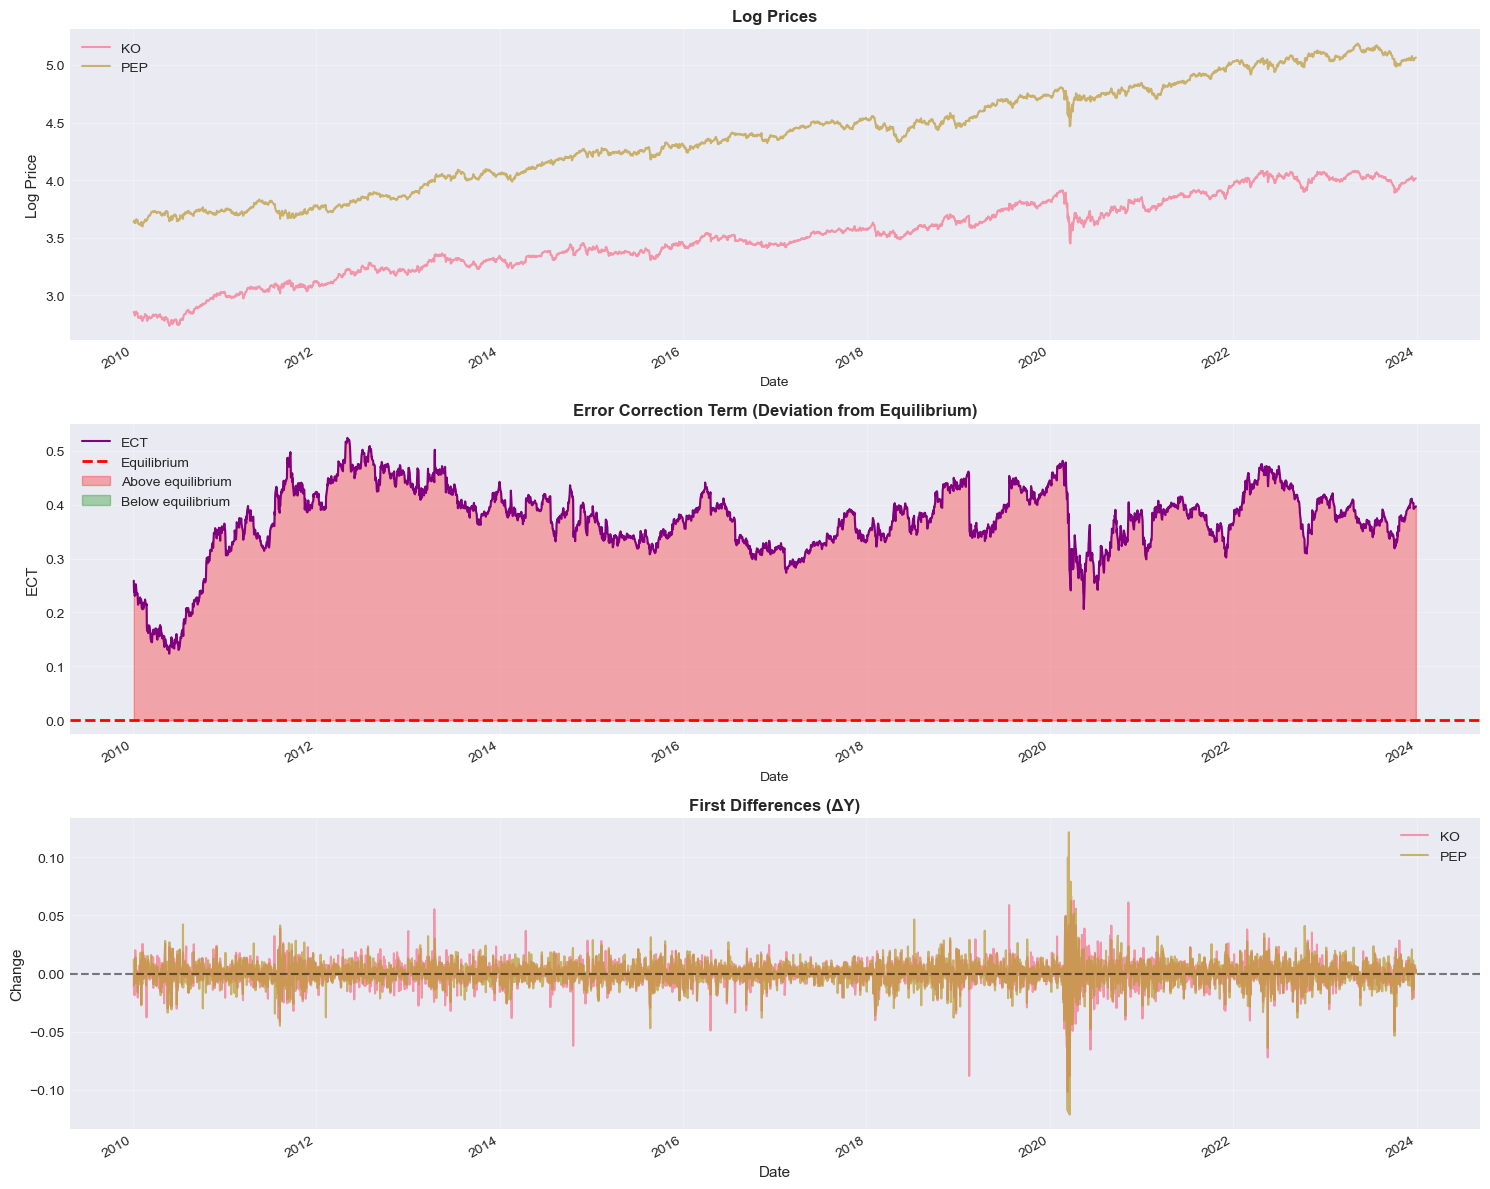


Key Insights:
• ECT oscillates around zero (mean-reverting)
• When ECT > 0: prices above equilibrium → expect correction
• When ECT < 0: prices below equilibrium → expect correction
• First differences are stationary


In [23]:
# Calculate and plot error correction term
# ECT = β'y_{t-1}
ect = (beta.T @ log_prices.T).T
ect.columns = ['ECT']

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Log prices
log_prices.plot(ax=axes[0], linewidth=1.5, alpha=0.7)
axes[0].set_title('Log Prices', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Log Price', fontsize=11)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Error correction term
ect.plot(ax=axes[1], linewidth=1.5, color='purple', legend=False)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2, 
               label='Equilibrium')
axes[1].fill_between(ect.index, 0, ect['ECT'].values.flatten(),
                     where=(ect['ECT'].values.flatten() > 0),
                     color='red', alpha=0.3, label='Above equilibrium')
axes[1].fill_between(ect.index, 0, ect['ECT'].values.flatten(),
                     where=(ect['ECT'].values.flatten() <= 0),
                     color='green', alpha=0.3, label='Below equilibrium')
axes[1].set_title('Error Correction Term (Deviation from Equilibrium)', 
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('ECT', fontsize=11)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

# Changes (first differences)
changes = log_prices.diff().dropna()
changes.plot(ax=axes[2], linewidth=1.5, alpha=0.7)
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[2].set_title('First Differences (ΔY)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=11)
axes[2].set_ylabel('Change', fontsize=11)
axes[2].legend(loc='best', fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("• ECT oscillates around zero (mean-reverting)")
print("• When ECT > 0: prices above equilibrium → expect correction")
print("• When ECT < 0: prices below equilibrium → expect correction")
print("• First differences are stationary")

## 4. Application: Pairs Trading

### 4.1 Concept

**Pairs trading**: Market-neutral strategy exploiting cointegration.

**Logic**:
1. Find two cointegrated assets
2. When spread widens: Short overvalued, long undervalued
3. When spread narrows: Close positions
4. Profit from mean reversion

### 4.2 Trading Rules

**Error correction term**: $z_t = y_{1t} - \beta y_{2t}$

**Signals**:
- $z_t > k \sigma_z$: Spread too high → Short asset 1, long asset 2
- $z_t < -k \sigma_z$: Spread too low → Long asset 1, short asset 2
- $|z_t| < 0.5 \sigma_z$: Close positions

where $k \in [1, 2.5]$ is threshold parameter.

### 4.3 Risk Management

**Considerations**:
- Cointegration can break down
- Transaction costs
- Execution risk
- Leverage constraints
- Monitoring adjustment speed

In [25]:
# Implement simple pairs trading strategy
print("\n" + "="*60)
print("Pairs Trading Strategy")
print("="*60)

# Calculate spread using cointegrating relationship
spread = log_prices['KO'] - (-beta[1,0]/beta[0,0]) * log_prices['PEP']
spread_mean = spread.mean()
spread_std = spread.std()

print(f"\nSpread Statistics:")
print(f"  Mean: {spread_mean:.4f}")
print(f"  Std Dev: {spread_std:.4f}")

# Define trading signals
threshold = 1.5  # Number of standard deviations
close_threshold = 0.5

signals = pd.DataFrame(index=log_prices.index)
signals['spread'] = spread
signals['z_score'] = (spread - spread_mean) / spread_std

# Generate positions
# Position = 1: Long spread (long KO, short PEP)
# Position = -1: Short spread (short KO, long PEP)
# Position = 0: No position
signals['position'] = 0

# Open position when spread exceeds threshold
signals.loc[signals['z_score'] > threshold, 'position'] = -1  # Short spread
signals.loc[signals['z_score'] < -threshold, 'position'] = 1   # Long spread

# Forward fill to maintain position
signals['position'] = signals['position'].replace(0, np.nan).ffill().fillna(0)

# Close position when spread near mean
close_long = (signals['z_score'] > -close_threshold) & (signals['position'] == 1)
close_short = (signals['z_score'] < close_threshold) & (signals['position'] == -1)
signals.loc[close_long | close_short, 'position'] = 0
signals['position'] = signals['position'].ffill()

# Calculate returns
returns = log_prices.diff()
signals['strategy_return'] = signals['position'].shift(1) * returns['KO']

# Performance metrics
cumulative_returns = (signals['strategy_return'].fillna(0) + 1).cumprod()
total_return = cumulative_returns.iloc[-1] - 1
annual_return = (1 + total_return) ** (252 / len(signals)) - 1
sharpe = signals['strategy_return'].mean() / signals['strategy_return'].std() * np.sqrt(252)

print(f"\nStrategy Performance:")
print(f"  Total Return: {total_return*100:.2f}%")
print(f"  Annualized Return: {annual_return*100:.2f}%")
print(f"  Sharpe Ratio: {sharpe:.2f}")
print(f"  Number of trades: {signals['position'].diff().abs().sum()/2:.0f}")


Pairs Trading Strategy

Spread Statistics:
  Mean: 0.3710
  Std Dev: 0.0665

Strategy Performance:
  Total Return: 206.46%
  Annualized Return: 8.34%
  Sharpe Ratio: 0.69
  Number of trades: 60


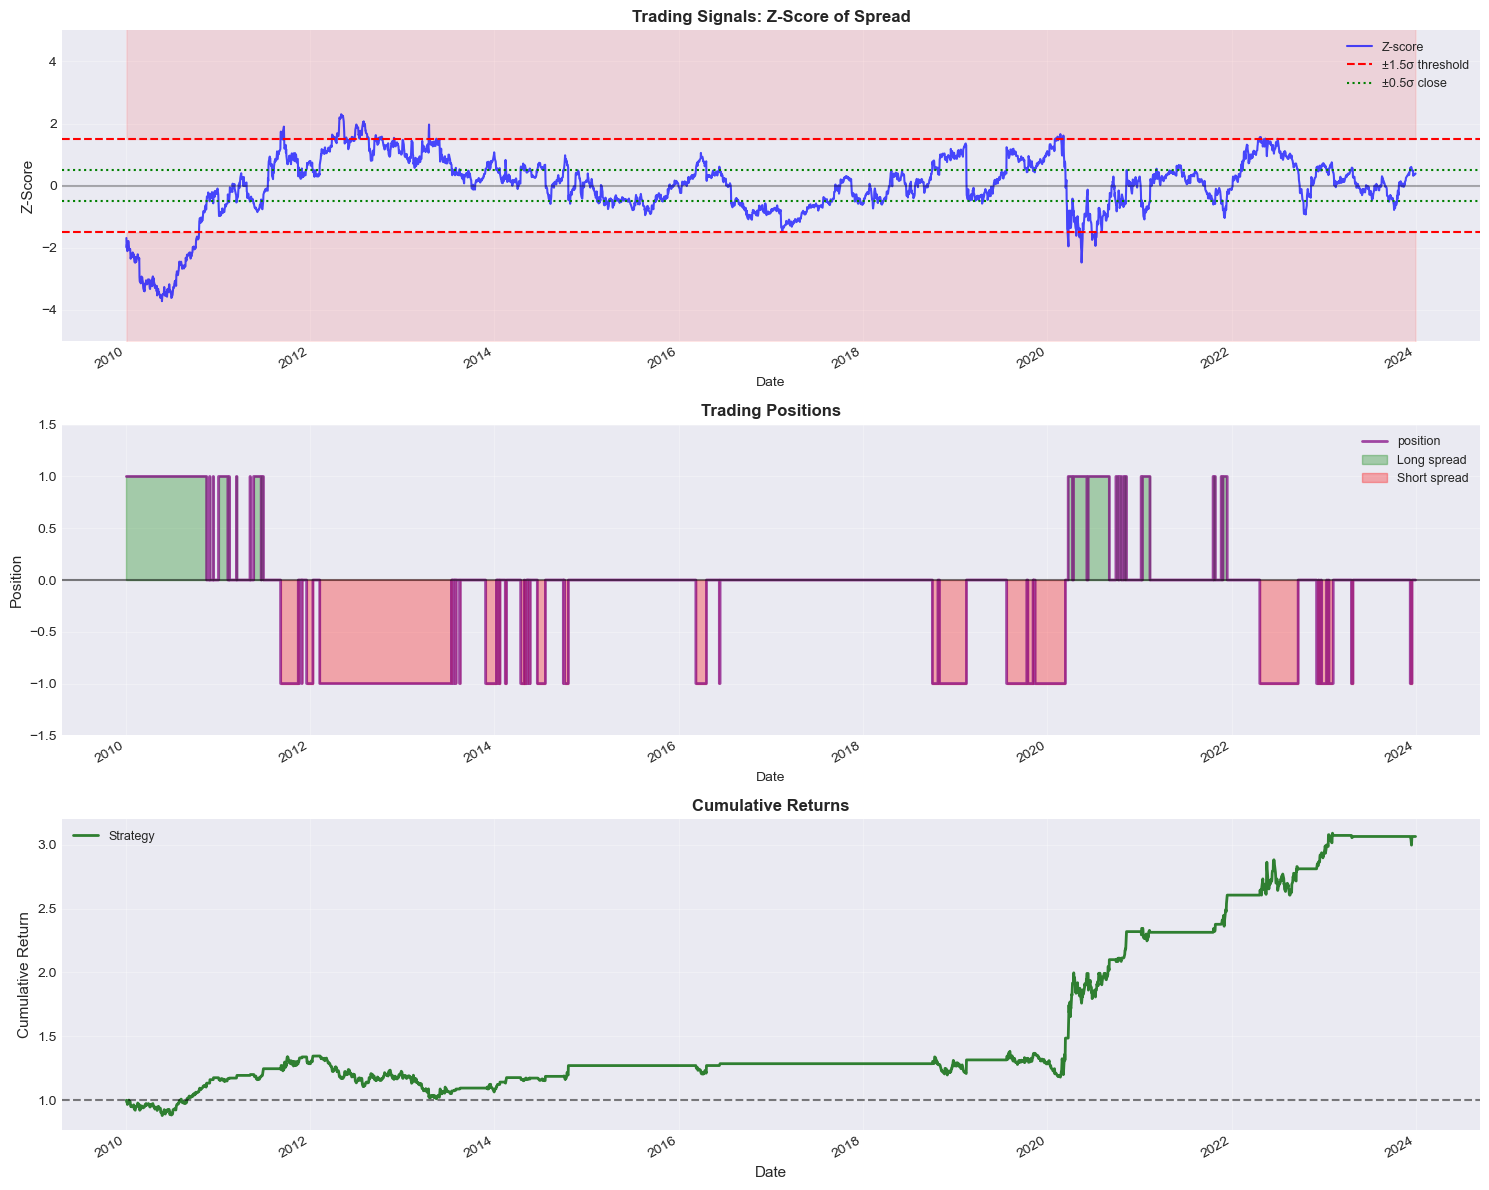


Strategy Insights:
• Enter when spread deviates significantly from mean
• Exit when spread returns to equilibrium
• Market-neutral: profits from mean reversion
• Requires careful monitoring of cointegration stability


In [27]:
# Visualize trading strategy
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Z-score with trading signals
signals['z_score'].plot(ax=axes[0], linewidth=1.5, color='blue', alpha=0.7,
                        label='Z-score')
axes[0].axhline(y=threshold, color='red', linestyle='--', linewidth=1.5,
               label=f'±{threshold}σ threshold')
axes[0].axhline(y=-threshold, color='red', linestyle='--', linewidth=1.5)
axes[0].axhline(y=close_threshold, color='green', linestyle=':', linewidth=1.5,
               label=f'±{close_threshold}σ close')
axes[0].axhline(y=-close_threshold, color='green', linestyle=':', linewidth=1.5)
axes[0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0].fill_between(signals.index, threshold, 10, alpha=0.1, color='red')
axes[0].fill_between(signals.index, -threshold, -10, alpha=0.1, color='red')
axes[0].set_title('Trading Signals: Z-Score of Spread', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Z-Score', fontsize=11)
axes[0].set_ylim(-5, 5)
axes[0].legend(loc='best', fontsize=9)
axes[0].grid(True, alpha=0.3)

# Positions
signals['position'].plot(ax=axes[1], linewidth=2, color='purple', alpha=0.7,
                        drawstyle='steps-post')
axes[1].fill_between(signals.index, 0, signals['position'], 
                     where=(signals['position'] > 0),
                     color='green', alpha=0.3, step='post', label='Long spread')
axes[1].fill_between(signals.index, 0, signals['position'],
                     where=(signals['position'] < 0),
                     color='red', alpha=0.3, step='post', label='Short spread')
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[1].set_title('Trading Positions', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Position', fontsize=11)
axes[1].set_ylim(-1.5, 1.5)
axes[1].legend(loc='best', fontsize=9)
axes[1].grid(True, alpha=0.3)

# Cumulative returns
cumulative_returns.plot(ax=axes[2], linewidth=2, color='darkgreen', alpha=0.8,
                       label='Strategy')
axes[2].axhline(y=1, color='black', linestyle='--', alpha=0.5)
axes[2].set_title('Cumulative Returns', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=11)
axes[2].set_ylabel('Cumulative Return', fontsize=11)
axes[2].legend(loc='best', fontsize=9)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nStrategy Insights:")
print("• Enter when spread deviates significantly from mean")
print("• Exit when spread returns to equilibrium")
print("• Market-neutral: profits from mean reversion")
print("• Requires careful monitoring of cointegration stability")

## 5. VECM Forecasting and Impulse Responses

### 5.1 VECM Forecasting

**h-step ahead forecast**:
$$\hat{\mathbf{y}}_{T+h|T} = \mathbf{y}_T + \sum_{j=1}^h \hat{\Delta}\mathbf{y}_{T+j|T}$$

where $\hat{\Delta}\mathbf{y}_{T+j|T}$ comes from VECM.

**Properties**:
- Respects long-run relationship
- Forecasts converge to equilibrium path
- Better long-horizon forecasts than VAR in differences

### 5.2 Impulse Response Functions

Same as VAR but interpreted differently:
- **Short-run IRF**: Immediate responses
- **Long-run IRF**: Permanent effects (constrained by cointegration)

**Cointegration restrictions**:
- Some shocks have no long-run effect
- Long-run multipliers determined by $\boldsymbol{\beta}$

### 5.3 Comparison with VAR

| Feature | VAR in differences | VECM |
|---------|-------------------|------|
| Long-run info | Discarded | Preserved |
| Forecasts | Satisfactory short-run | Better long-run |
| Parameters | More efficient | More structured |
| Interpretation | Harder | Clearer (equilibrium) |

In [29]:
# VECM forecasting
print("\n" + "="*60)
print("VECM Forecasting")
print("="*60)

# Split data
train_size = int(len(log_prices) * 0.95)
train_data = log_prices[:train_size]
test_data = log_prices[train_size:]

print(f"\nTraining: {len(train_data)} observations")
print(f"Test: {len(test_data)} observations")

# Fit VECM on training data
vecm_train = VECM(train_data, k_ar_diff=selected_lag, coint_rank=1, deterministic='ci')
vecm_train_fit = vecm_train.fit()

# Generate forecasts
forecast_steps = len(test_data)
forecast = vecm_train_fit.predict(steps=forecast_steps)

# Create forecast DataFrame
forecast_df = pd.DataFrame(forecast, index=test_data.index, columns=log_prices.columns)

# Calculate errors
errors = test_data - forecast_df

# Metrics
print("\nForecast Accuracy:")
for col in log_prices.columns:
    mae = np.abs(errors[col]).mean()
    rmse = np.sqrt((errors[col]**2).mean())
    print(f"\n{col}:")
    print(f"  MAE:  {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")


VECM Forecasting

Training: 3345 observations
Test: 177 observations

Forecast Accuracy:

KO:
  MAE:  0.0530
  RMSE: 0.0660

PEP:
  MAE:  0.0463
  RMSE: 0.0594


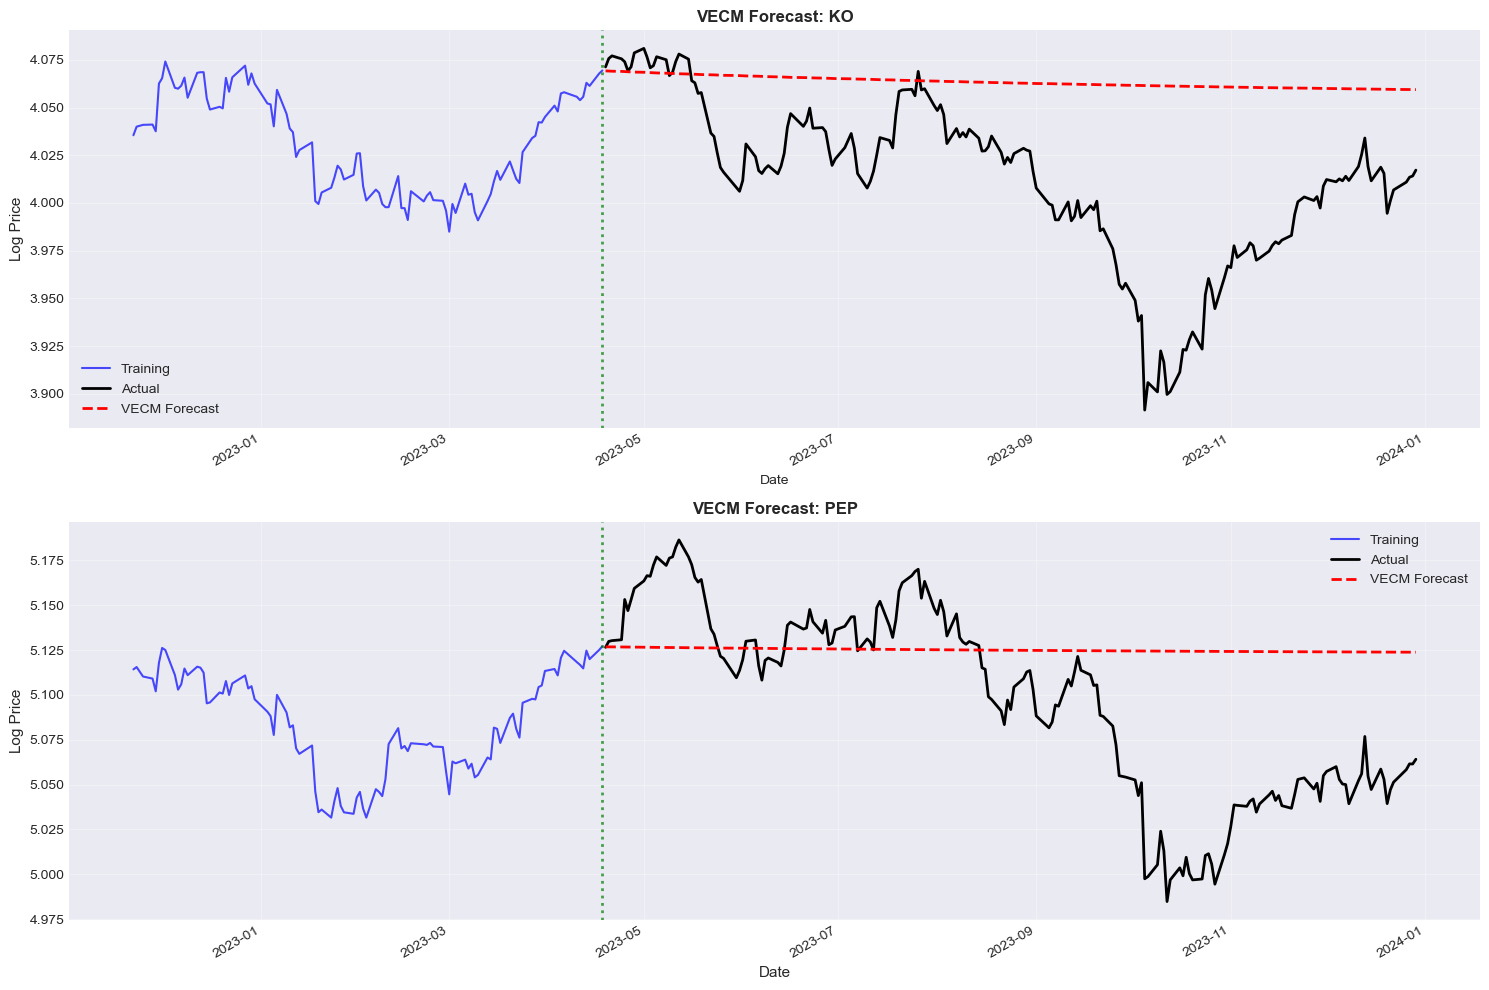


Forecasting Insights:
• VECM respects long-run equilibrium
• Forecasts don't diverge unrealistically
• Better for long-horizon forecasts
• Captures mean reversion


In [31]:
# Visualize forecasts
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

for idx, col in enumerate(log_prices.columns):
    # Historical
    train_data[col].iloc[-100:].plot(ax=axes[idx], linewidth=1.5,
                                     label='Training', color='blue', alpha=0.7)
    # Actual test
    test_data[col].plot(ax=axes[idx], linewidth=2,
                       label='Actual', color='black')
    # Forecast
    forecast_df[col].plot(ax=axes[idx], linewidth=2,
                         label='VECM Forecast', color='red', style='--')
    
    axes[idx].axvline(x=train_data.index[-1], color='green',
                     linestyle=':', alpha=0.7, linewidth=2)
    axes[idx].set_title(f'VECM Forecast: {col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Log Price', fontsize=11)
    axes[idx].legend(loc='best', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

axes[1].set_xlabel('Date', fontsize=11)

plt.tight_layout()
plt.show()

print("\nForecasting Insights:")
print("• VECM respects long-run equilibrium")
print("• Forecasts don't diverge unrealistically")
print("• Better for long-horizon forecasts")
print("• Captures mean reversion")

## 6. Summary and Best Practices

### 6.1 Cointegration Testing Workflow

**Step 1: Test for Unit Roots**
- ADF test on each series
- All should be I(1)
- If mixed orders, cointegration not applicable

**Step 2: Test for Cointegration**
- Engle-Granger for bivariate
- Johansen for multivariate
- Determine cointegration rank

**Step 3: Estimate VECM**
- Select lag length
- Estimate cointegrating vectors
- Interpret adjustment coefficients

**Step 4: Diagnostics**
- Check residuals for serial correlation
- Test normality if needed
- Verify stability

**Step 5: Analysis**
- Interpret long-run relationships
- Examine short-run dynamics
- IRFs and variance decomposition
- Forecasting

### 6.2 Common Applications

| Application | Variables | Interpretation |
|-------------|-----------|---------------|
| PPP | Exchange rate, price levels | Purchasing power equilibrium |
| Term structure | Short rate, long rate | Expectations theory |
| Money demand | Money, income, interest rate | Long-run money demand |
| Pairs trading | Related stock prices | Arbitrage relationship |
| Spot-futures | Spot price, futures price | Cost of carry |

### 6.3 Key Takeaways

**Cointegration**:
- Long-run equilibrium relationship
- I(1) variables can have stable combination
- Avoids spurious regression
- Economic meaning: forces bind variables

**VECM**:
- Correct model for cointegrated variables
- Separates long-run and short-run
- Error correction mechanism
- Better forecasts than VAR in differences

**Testing**:
- Engle-Granger: Simple, bivariate
- Johansen: Multivariate, tests rank
- Both have good power

**Applications**:
- Pairs trading strategies
- Economic theory testing
- Long-run forecasting
- Policy analysis

### 6.4 Limitations

- **Parameter instability**: Cointegration can break
- **Structural breaks**: Test stability over time
- **Small samples**: Tests have low power
- **Lag selection**: Sensitive to choice
- **Identification**: Cointegrating vectors not unique

### 6.5 Extensions

- **Threshold cointegration**: Asymmetric adjustment
- **Time-varying cointegration**: Non-constant relationships
- **Fractional cointegration**: Long memory
- **Regime-switching**: Markov-switching VECM

### 6.6 Next Session Preview

In **Sessions 10-11**, we will cover:
- Time-Varying Parameter models
- TVP-VAR specification
- Kalman filter estimation
- Dynamic spillovers and connectedness
- Applications to financial contagion

## 7. Exercises

### Exercise 1: Spurious Regression
Demonstrate spurious regression:
1. Simulate two independent random walks
2. Regress one on the other
3. Report R², t-statistics, DW statistic
4. Repeat 1000 times, plot distribution of R²
5. What fraction appear "significant"?

### Exercise 2: Cointegration Testing
For EUR/USD and GBP/USD exchange rates:
1. Download daily data (5+ years)
2. Test each for unit root
3. Perform Engle-Granger test
4. Perform Johansen test
5. Are they cointegrated? Economic interpretation?

### Exercise 3: VECM Estimation
For spot and futures gold prices:
1. Test for cointegration
2. Estimate VECM
3. Extract cointegrating vector
4. Interpret adjustment coefficients
5. Which market leads? (weakly exogenous?)

### Exercise 4: Pairs Trading
Implement pairs trading strategy:
1. Find two cointegrated stocks
2. Calculate optimal hedge ratio
3. Define trading rules (entry/exit thresholds)
4. Backtest over 2-3 years
5. Calculate Sharpe ratio, maximum drawdown

### Exercise 5: Forecasting Comparison
Compare VECM vs VAR forecasts:
1. Use cointegrated variables
2. Fit VECM and VAR in differences
3. Generate 1 to 20 step ahead forecasts
4. Calculate RMSE at each horizon
5. Which performs better? When?

In [ ]:
# Space for your solutions to exercises

# Exercise 1:
# Your code here

# Exercise 2:
# Your code here

# Exercise 3:
# Your code here

# Exercise 4:
# Your code here

# Exercise 5:
# Your code here

## References and Further Reading

### Seminal Papers:
1. Engle, R.F., & Granger, C.W.J. (1987). Co-integration and error correction: Representation, estimation, and testing. *Econometrica*, 55(2), 251-276.
2. Johansen, S. (1988). Statistical analysis of cointegration vectors. *Journal of Economic Dynamics and Control*, 12(2-3), 231-254.
3. Granger, C.W.J., & Newbold, P. (1974). Spurious regressions in econometrics. *Journal of Econometrics*, 2(2), 111-120.
4. Stock, J.H., & Watson, M.W. (1988). Testing for common trends. *Journal of the American Statistical Association*, 83(404), 1097-1107.

### Textbooks:
1. Johansen, S. (1995). *Likelihood-Based Inference in Cointegrated Vector Autoregressive Models*. Oxford University Press.
2. Hamilton, J.D. (1994). *Time Series Analysis*. Princeton University Press. Chapters 19-20.
3. Enders, W. (2014). *Applied Econometric Time Series* (4th ed.). Wiley. Chapter 6.
4. Lütkepohl, H. (2005). *New Introduction to Multiple Time Series Analysis*. Springer. Chapters 6-7.

### Applied Papers:
1. Gatev, E., Goetzmann, W.N., & Rouwenhorst, K.G. (2006). Pairs trading: Performance of a relative-value arbitrage rule. *Review of Financial Studies*, 19(3), 797-827.
2. Alexander, C. (1999). Optimal hedging using cointegration. *Philosophical Transactions of the Royal Society A*, 357(1758), 2039-2058.

### Software:
1. Statsmodels VECM: https://www.statsmodels.org/stable/vector_ar.html
2. urca package (R): https://cran.r-project.org/package=urca
3. PyFlux: https://pyflux.readthedocs.io/

### Online Resources:
1. Kevin Sheppard's Notes: https://www.kevinsheppard.com/
2. NBER: https://www.nber.org/

---

**Instructor Contact**: [Mathis J.F. Mourey. mjfmourey@hhs.nl]

**Office Hours**: [Mon-Fri 9am-5pm]